In [1]:
import numpy as np
import pandas as pd
import pygmo
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib 
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error, r2_score

from config import MAX_DISCOUNT, FEATURES

%matplotlib inline

In [2]:
df=pd.read_csv('training_data_randn.csv')
cols_x = FEATURES
col_y = 'is_deal'
col_p = 'Probability'
print(df.shape)

(1000000, 22)


In [3]:
n_train = int(0.8*len(df))
x = df[cols_x]
x_train = x[:n_train]
x_test  = x[n_train:]
y_train = df[col_y][:n_train]
y_test = df[col_y][n_train:]
p_train = df[col_p][:n_train]
p_test = df[col_p][n_train:]

In [4]:
scaler = StandardScaler()
mlp = MLPClassifier(hidden_layer_sizes=(12, 4), 
                    activation='tanh', 
                    alpha=1e-5,  # L2 reg
                    max_iter=10, 
                    batch_size=128, 
                    random_state=1, 
                    validation_fraction=0.2)
model = Pipeline([('scalar', scaler), ('mlp', mlp)])
model.fit(x_train, y_train)


C:\Users\jiahang.zhong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
     steps=[('scalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', MLPClassifier(activation='tanh', alpha=1e-05, batch_size=128, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(12, 4), learning_rate='constant',
       learning_rate_i...       solver='adam', tol=0.0001, validation_fraction=0.2, verbose=False,
       warm_start=False))])

In [5]:
y_pred_train = model.predict_proba(x_train)[:, 1]
y_pred_test = model.predict_proba(x_test)[:, 1]

In [6]:
# rand x_i: 0.764
# randn x_i: 0.784
# unity x_i: 0.85
roc_auc_score(y_train, y_pred_train), roc_auc_score(y_test, y_pred_test)

(0.753230369515837, 0.7548146375066427)

In [7]:
print(np.sqrt(mean_squared_error(p_train, y_pred_train)), mean_absolute_error(p_train, y_pred_train),r2_score(p_train, y_pred_train) )
print(np.sqrt(mean_squared_error(p_test, y_pred_test)), mean_absolute_error(p_test, y_pred_test),r2_score(p_test, y_pred_test) )

0.037916594236513924 0.028807461772473918 0.9709064703607538
0.03793327316965178 0.028832196346147775 0.9709202360264974


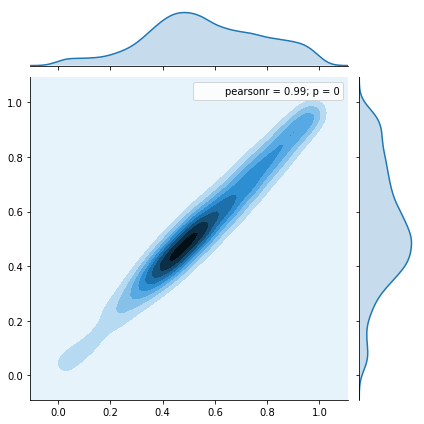

In [8]:
sns.jointplot(x=p_test.values[:10000], y=y_pred_test[:10000], kind="kde")

In [9]:
joblib.dump(model, 'propensity_model_sklearn_mlp.pkl') 

['propensity_model_sklearn_mlp.pkl']